<a href="https://colab.research.google.com/github/Josh-Tang112/Temperature_Map/blob/main/Temperature_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ipyleaflet
!jupyter nbextension enable --py --sys-prefix ipyleaflet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.9 MB/s eta 0:00:00
Enabling notebook extension jupyter-leaflet/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


In [23]:
from ipywidgets import HTML
from ipyleaflet import Map, Marker, Popup, basemaps
import requests
from io import BytesIO, StringIO
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import base64

In [20]:
# get necessary metadata
url = 'https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'
r = requests.get(url)
stations = r.content.decode('utf-8').split('\n')
stations = stations[:-1]
stations[:2]

['ACW00011604  17.1167  -61.7833   10.1    ST JOHNS COOLIDGE FLD                       ',
 'ACW00011647  17.1333  -61.7833   19.2    ST JOHNS                                    ']

In [21]:
# find the name of the closest station
def get_station_name(lat,lng):
    min_name = ''
    min_distance = -1
    for line in stations:
        token = re.split('[ ]+',line)
        distance = math.sqrt((float(token[1]) - lat)**2 + (float(token[2]) - lng)**2)
        if min_distance < 0:
            min_distance = distance
        elif min_distance > distance:
            min_distance = distance
            min_name = token[0]
    return min_name

In [43]:
# data processing
def drop_out_NULL(df):
    # value of -9999 indicates missing
    return df.drop(df.loc[df['VALUE1']==-9999].index.values.astype(int))
def drop_out_non_temperature(df):
    # I'm only interested in temperature data
    return df.loc[(df['ELEMENT']=='TMIN') | (df['ELEMENT']=='TMAX')]

def get_fig(station_name, BIO):
    baseURL = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_station/"
    filename = f"{station_name}.csv.gz"
    outFilePath = f"{station_name}.csv"

    r = requests.get(baseURL + filename)
    compressedFile = BytesIO()
    compressedFile.write(r.content)
    compressedFile.seek(0)

    decompressedFile = gzip.GzipFile(fileobj=compressedFile, mode='rb')

    # with open(outFilePath, 'wb') as outfile:
    #     outfile.write(decompressedFile.read())

    buffer = StringIO()
    buffer.write("ID,DATE,ELEMENT,VALUE1,MFLAG,QFLAG,SFLAG,VALUE2\n")
    buffer.write(decompressedFile.read().decode("utf-8"))
    buffer.seek(0)
    df = pd.read_csv(buffer)

    flag = [0,0]
    if len(df.loc[(df['ELEMENT']=='TMAX')]) > 0:
        flag[0] = 1
    if len(df.loc[(df['ELEMENT']=='TMIN')]) > 0:
        flag[1] = 1
    if flag[0] == 0 and flag[1] == 0:
        return 0

    df = drop_out_non_temperature(df)
    df = drop_out_NULL(df)
    df['VALUE1'] = df['VALUE1'].map(lambda x : x / 10) # values of temperature arein tenths of celsius
    df['DATE'] = df['DATE'].map(lambda x : int(x / 10000)) # I'm only interested in yearly average
    df = df[['DATE','ELEMENT','VALUE1']]
    df = df.groupby(['ELEMENT','DATE']).mean()

    # creating the graph
    if flag[0] == 1:
        plt.plot(df.loc['TMAX'].index,np.reshape(df.loc['TMAX'].values,
            len(df.loc['TMAX'].values)),label="Yearly Average Max Temperature")
    if flag[1] == 1:
        plt.plot(df.loc['TMIN'].index,np.reshape(df.loc['TMIN'].values,
            len(df.loc['TMIN'].values)),label="Yearly Average Min Temperature")
    plt.ylabel("Temperature in Celsius")
    plt.xlabel("Year")
    plt.legend()
    plt.savefig(BIO,format='jpg')

    return 1

Map(center=[37.0902, -95.7129], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

<ipython-input-43-969851f78bb8>:28: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(buffer)


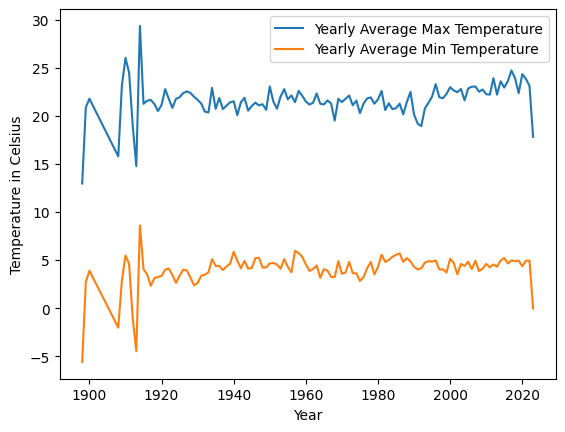

In [44]:
from ipywidgets import Layout
defaultLayout=Layout(width='1920px', height='1040px')

m = Map(basemap=basemaps.OpenStreetMap.HOT, center=(37.0902, -95.7129), zoom=6, layout=defaultLayout)
def handle_click(**kwargs):
    if kwargs.get('type') == 'click':
        img = BytesIO()
        coord = kwargs.get('coordinates')
        res = get_fig(get_station_name(coord[0], coord[1]), img)
        
        pic = HTML()
        if res == 1:
            img.seek(0)
            encoded = base64.b64encode(img.read())
            pic.value = '<img src="data:image/jpg;base64,{}">'.format(encoded.decode('utf-8'))
        else:
            pic.value = '<b>There is no temperature data in the nearest station</b>'

        popup = Popup(
            location=coord,
            child=pic,
        )
        m.add_layer(popup)

m.on_interaction(handle_click)
m